In [5]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
ts = pd.read_csv("../data/processed/reports/combined.csv")
# Dodanie kolumny ret_1d_log dla całego DataFrame


ts

,symbol,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap
0,acp,2015-01-02,30.0026,30.3974,29.6386,29.6386,106754,NaN,0
1,acp,2015-01-05,29.5031,29.9623,29.2865,29.8381,158005,0.006731,0
2,acp,2015-01-07,29.9032,31.1305,29.4090,30.9780,181319,0.038203,0
3,acp,2015-01-08,30.9592,31.7240,30.6484,31.6640,240391,0.022145,0
4,acp,2015-01-09,31.6066,31.6066,30.9190,31.1956,96704,-0.014793,0
...,...,...,...,...,...,...,...,...,...
37992,tpe,2025-11-03,10.0300,10.1200,9.8220,9.9000,1498322,-0.010000,0
37993,tpe,2025-11-04,9.9000,10.1200,9.8360,10.1000,1698516,0.020202,0
37994,tpe,2025-11-05,10.0850,10.5600,9.9900,10.4600,4709271,0.035644,0
37995,tpe,2025-11-06,10.4600,10.6200,10.1600,10.5700,4061709,0.010516,0


In [19]:
# Rozdzielenie na szereg czasowy dla każdego symbolu
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ret_1d',
'flag_abnormal_gap']

# Usunięcie kolumn bez nazwy (np. "Unnamed")
ts = ts.loc[:, ~ts.columns.str.contains('^Unnamed')]

# Filtracja danych, aby zawierały tylko wymagane kolumny
filtered_ts = ts[[col for col in required_columns if col in ts.columns] + ['symbol']]

# Grupowanie po symbolu i tworzenie słownika
time_series_dict = {}
for symbol, group in filtered_ts.groupby('symbol'):
    # Sortowanie danych w grupie po dacie (jeśli nie są posortowane)
    group = group.sort_values(by='date')

    # Dodanie kolumn specyficznych dla każdej spółki
    group['ret_1d_log'] = np.log(1 + group['ret_1d'])
    for lag in range(1, 5):  # Tworzenie lagów od 1 do 10
        group[f'ireturn_lag{lag}'] = group['ret_1d'].shift(lag)
        group[f'log_return_lag{lag}'] = group['ret_1d_log'].shift(lag)

    group = group.dropna()


    # Przechowywanie przetworzonej grupy w słowniku
    time_series_dict[symbol] = group


time_series_dict["acp"]


,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap,symbol,ret_1d_log,ireturn_lag1,log_return_lag1,ireturn_lag2,log_return_lag2,ireturn_lag3,log_return_lag3,ireturn_lag4,log_return_lag4
5,2015-01-12,30.9429,31.1365,30.8487,31.0192,120156,-0.005655,0,acp,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491,0.006731,0.006709
6,2015-01-13,31.1365,32.1368,31.0259,32.0187,237657,0.032222,0,acp,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491
7,2015-01-14,31.9603,31.9603,30.9318,31.4423,188742,-0.018002,0,acp,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903
8,2015-01-15,31.5296,31.9296,31.2606,31.4713,625585,0.000922,0,acp,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903
9,2015-01-16,31.0012,31.7240,30.7254,31.3728,183987,-0.003130,0,acp,-0.003135,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2025-11-03,215.6000,218.6000,214.2000,217.2000,81410,0.011173,0,acp,0.011111,-0.033303,-0.033871,-0.038095,-0.038840,-0.001729,-0.001730,0.021183,0.020961
2712,2025-11-04,217.0000,217.0000,209.0000,211.8000,77888,-0.024862,0,acp,-0.025176,0.011173,0.011111,-0.033303,-0.033871,-0.038095,-0.038840,-0.001729,-0.001730
2713,2025-11-05,210.0000,211.2000,204.6000,211.2000,156582,-0.002833,0,acp,-0.002837,-0.024862,-0.025176,0.011173,0.011111,-0.033303,-0.033871,-0.038095,-0.038840
2714,2025-11-06,207.6000,207.6000,195.1000,199.9000,232424,-0.053504,0,acp,-0.054988,-0.002833,-0.002837,-0.024862,-0.025176,0.011173,0.011111,-0.033303,-0.033871


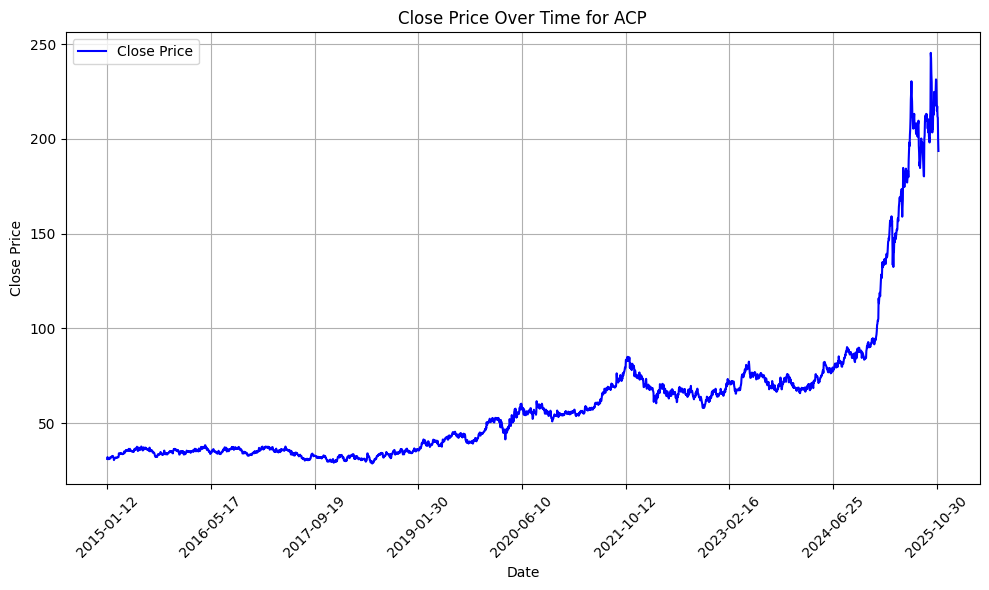

In [20]:
pkn_data = time_series_dict["acp"]

# Wykres wartości 'close' w czasie
plt.figure(figsize=(10, 6))
plt.plot(pkn_data['date'], pkn_data['close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time for ACP')
plt.legend()
plt.grid(True)

# Wyświetlanie etykiet co 1/8 danych
num_labels = len(pkn_data['date'])
step = max(1, num_labels // 8)  # Co 1/8 danych
plt.xticks(ticks=pkn_data['date'][::step], labels=pkn_data['date'][::step], rotation=45)

plt.tight_layout()
plt.show()

In [69]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)


class NonLinearModel(nn.Module):
    def __init__(self, input_features, hidden_size=64):
        super(NonLinearModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_features, hidden_size),
            nn.ReLU(),  # Non-linear activation
            nn.Linear(hidden_size , 1)  # Output layer
        )

    def forward(self, x):
        return self.network(x)

class AdvancedModel(nn.Module):
    def __init__(self, input_features, hidden_sizes=[16, 32, 16], dropout_rate=0.3):
        super(AdvancedModel, self).__init__()
        layers = []
        in_features = input_features

        # Tworzenie warstw ukrytych
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU jako funkcja aktywacji
            layers.append(nn.Dropout(dropout_rate))  # Dropout dla regularizacji
            in_features = hidden_size

        # Warstwa wyjściowa
        layers.append(nn.Linear(in_features, 1))  # Wyjście: jedna wartość

        # Definiowanie sieci
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Warstwa LSTM
        self.lstm = nn.LSTM(input_features, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Warstwa w pełni połączona (wyjściowa)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Inicjalizacja stanów ukrytych i komórkowych
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan ukryty
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan komórkowy

        # Przepływ przez LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Przepływ przez warstwę w pełni połączoną (tylko ostatni krok czasowy)
        out = self.fc(out[:, -1, :])  # Używamy tylko ostatniego kroku czasowego
        return out

In [22]:
features = [f'log_return_lag{lag}' for lag in range(1, 5)]
target = 'ret_1d_log'
test_size = 0.25

In [23]:

len(time_series_dict["acp"])

int(len(time_series_dict["acp"]) * test_size)



split_idx = int(len(time_series_dict["acp"]) * (1-test_size))
split_idx

2033

In [24]:

ts_train, ts_test = time_series_dict["acp"][:split_idx], time_series_dict["acp"][split_idx:]
ts_train = ts_train.dropna(subset=features + [target])
ts_test = ts_test.dropna(subset=features + [target])


ts_train

,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap,symbol,ret_1d_log,ireturn_lag1,log_return_lag1,ireturn_lag2,log_return_lag2,ireturn_lag3,log_return_lag3,ireturn_lag4,log_return_lag4
5,2015-01-12,30.9429,31.1365,30.8487,31.0192,120156,-0.005655,0,acp,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491,0.006731,0.006709
6,2015-01-13,31.1365,32.1368,31.0259,32.0187,237657,0.032222,0,acp,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491
7,2015-01-14,31.9603,31.9603,30.9318,31.4423,188742,-0.018002,0,acp,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903
8,2015-01-15,31.5296,31.9296,31.2606,31.4713,625585,0.000922,0,acp,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903
9,2015-01-16,31.0012,31.7240,30.7254,31.3728,183987,-0.003130,0,acp,-0.003135,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,2023-02-16,72.3934,72.5728,71.2720,72.2139,62810,0.000000,0,acp,0.000000,0.017699,0.017544,-0.005657,-0.005673,0.010800,0.010742,-0.036129,-0.036798
2034,2023-02-17,72.2139,72.2139,71.3169,71.5411,41984,-0.009317,0,acp,-0.009360,0.000000,0.000000,0.017699,0.017544,-0.005657,-0.005673,0.010800,0.010742
2035,2023-02-20,71.7654,71.8551,70.6890,71.0926,38192,-0.006269,0,acp,-0.006289,-0.009317,-0.009360,0.000000,0.000000,0.017699,0.017544,-0.005657,-0.005673
2036,2023-02-21,71.0926,71.2720,69.6573,70.6890,49957,-0.005677,0,acp,-0.005693,-0.006269,-0.006289,-0.009317,-0.009360,0.000000,0.000000,0.017699,0.017544


In [25]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [26]:
X_train


tensor([[-0.0149,  0.0219,  0.0375,  0.0067],
        [-0.0057, -0.0149,  0.0219,  0.0375],
        [ 0.0317, -0.0057, -0.0149,  0.0219],
        ...,
        [-0.0094,  0.0000,  0.0175, -0.0057],
        [-0.0063, -0.0094,  0.0000,  0.0175],
        [-0.0057, -0.0063, -0.0094,  0.0000]])

In [27]:
y_train = y_train.reshape(-1, 1)

y_test = y_test.reshape(-1, 1)
y_train

tensor([[-0.0057],
        [ 0.0317],
        [-0.0182],
        ...,
        [-0.0063],
        [-0.0057],
        [-0.0038]])

In [28]:
input_features = X_train.shape[1]  # Liczba cech wejściowych
model = LinearModel(input_features)

# Definicja funkcji kosztu i optymalizatora
criterion = nn.MSELoss()  # Funkcja kosztu: średni błąd kwadratowy
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Optymalizator: Adam

# Parametry treningu
num_epochs = 400  # Liczba epok
batch_size = 64  # Rozmiar batcha

# Funkcja do dzielenia danych na batch'e
def create_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Trening modelu
for epoch in range(num_epochs):
    model.train()  # Tryb treningowy
    epoch_loss = 0.0

    # Tworzenie batch'y
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        optimizer.zero_grad()  # Wyzerowanie gradientów
        outputs = model(X_batch)  # Przewidywania modelu
        loss = criterion(outputs, y_batch)  # Obliczenie straty
        loss.backward()  # Propagacja wsteczna
        optimizer.step()  # Aktualizacja wag
        epoch_loss += loss.item()

    # Wyświetlanie straty co 10 epok
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Testowanie modelu
model.eval()  # Tryb ewaluacji
with torch.no_grad():
    y_pred = model(X_test)  # Przewidywania na zbiorze testowym
    test_loss = criterion(y_pred, y_test)  # Obliczenie straty na zbiorze testowym

print(f"Test Loss: {test_loss.item():.4f}")

Epoch [10/400], Loss: 3.6618
Epoch [20/400], Loss: 1.5206
Epoch [30/400], Loss: 0.5233
Epoch [40/400], Loss: 0.1458
Epoch [50/400], Loss: 0.0363
Epoch [60/400], Loss: 0.0132
Epoch [70/400], Loss: 0.0098
Epoch [80/400], Loss: 0.0094
Epoch [90/400], Loss: 0.0093
Epoch [100/400], Loss: 0.0093
Epoch [110/400], Loss: 0.0092
Epoch [120/400], Loss: 0.0092
Epoch [130/400], Loss: 0.0092
Epoch [140/400], Loss: 0.0092
Epoch [150/400], Loss: 0.0092
Epoch [160/400], Loss: 0.0092
Epoch [170/400], Loss: 0.0092
Epoch [180/400], Loss: 0.0092
Epoch [190/400], Loss: 0.0092
Epoch [200/400], Loss: 0.0092
Epoch [210/400], Loss: 0.0092
Epoch [220/400], Loss: 0.0092
Epoch [230/400], Loss: 0.0092
Epoch [240/400], Loss: 0.0092
Epoch [250/400], Loss: 0.0092
Epoch [260/400], Loss: 0.0092
Epoch [270/400], Loss: 0.0092
Epoch [280/400], Loss: 0.0092
Epoch [290/400], Loss: 0.0092
Epoch [300/400], Loss: 0.0092
Epoch [310/400], Loss: 0.0092
Epoch [320/400], Loss: 0.0092
Epoch [330/400], Loss: 0.0092
Epoch [340/400], Lo

In [65]:
import polars as pl
import torch

threshold = 0.0005

model.eval()
with torch.no_grad():
    y_hat = model(X_test).numpy()

trade_results = (
    pl.DataFrame({
        "y_hat": y_hat.squeeze(),
        "y": y_test.numpy().squeeze(),
    })
    # surowy sygnał z modelu
    .with_columns(
        pl.col("y_hat").sign().alias("raw_signal")
    )
    # tylko pewne sygnały, reszta = 0 (brak nowego sygnału)
    .with_columns(
        pl.when(pl.col("y_hat").abs() >= threshold)
          .then(pl.col("raw_signal"))
          .otherwise(0)
          .alias("signal")
    )
    # tutaj tworzymy POZYCJĘ:
    # 1) zamień 0 na null (0 = "brak nowego sygnału")
    # 2) forward_fill -> wypełnij braki poprzednią nie-null wartością
    # 3) brak czegokolwiek na początku -> 0 (cash)
    .with_columns(
        pl.when(pl.col("signal") == 0)
          .then(None)
          .otherwise(pl.col("signal"))
          .alias("signal_ff")
    )
    .with_columns(
        pl.col("signal_ff")
          .forward_fill()
          .fill_null(0)
          .alias("position")
    )
    # teraz dopiero liczysz PnL z pozycji, nie z „chwilowego sygnału”
    .with_columns(
        (pl.col("position") * pl.col("y")).alias("trade_log_return")
    )
    .with_columns(
        pl.col("trade_log_return").cum_sum().alias("equity_curve")
    )
)

print(trade_results)


shape: (678, 8)
┌───────────┬───────────┬────────────┬────────┬───────────┬──────────┬──────────────┬──────────────┐
│ y_hat     ┆ y         ┆ raw_signal ┆ signal ┆ signal_ff ┆ position ┆ trade_log_re ┆ equity_curve │
│ ---       ┆ ---       ┆ ---        ┆ ---    ┆ ---       ┆ ---      ┆ turn         ┆ ---          │
│ f32       ┆ f32       ┆ f32        ┆ f32    ┆ f32       ┆ f32      ┆ ---          ┆ f32          │
│           ┆           ┆            ┆        ┆           ┆          ┆ f32          ┆              │
╞═══════════╪═══════════╪════════════╪════════╪═══════════╪══════════╪══════════════╪══════════════╡
│ 0.002957  ┆ -0.000639 ┆ 1.0        ┆ 1.0    ┆ 1.0       ┆ 1.0      ┆ -0.000639    ┆ -0.000639    │
│ 0.002054  ┆ 0.005721  ┆ 1.0        ┆ 1.0    ┆ 1.0       ┆ 1.0      ┆ 0.005721     ┆ 0.005082     │
│ 0.000288  ┆ 0.016965  ┆ 1.0        ┆ 0.0    ┆ null      ┆ 1.0      ┆ 0.016965     ┆ 0.022047     │
│ -0.002909 ┆ -0.004997 ┆ -1.0       ┆ -1.0   ┆ -1.0      ┆ -1.0     ┆ 0.00

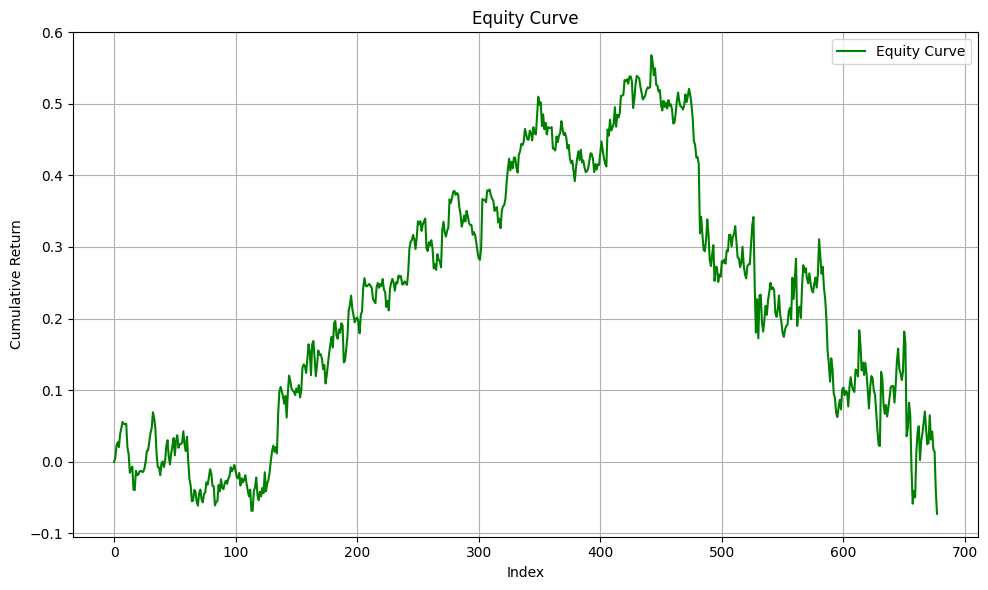

In [66]:
# Wykres equity_curve
plt.figure(figsize=(10, 6))
plt.plot(trade_results['equity_curve'], label='Equity Curve', color='green')
plt.xlabel('Index')
plt.ylabel('Cumulative Return')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
maker_fee = 0.0001
taker_fee = 0.003

# zakładamy, że każda zmiana pozycji idzie jako taker
# log-fee dla JEDNEJ strony transakcji (open LUB close)
one_side_fee_log = np.log(1 - taker_fee)

trade_results = (
    trade_results
    # poprzednia pozycja
    .with_columns(
        pl.col("position")
          .shift(1)
          .fill_null(0)
          .alias("position_prev")
    )
    # zmiana pozycji:
    # 0 -> 0: 0
    # 0 -> 1 / 0 -> -1 / 1 -> 0 / -1 -> 0: 1 (jedna transakcja)
    # 1 -> -1 / -1 -> 1: 2 (zamknięcie + otwarcie)
    .with_columns(
        (pl.col("position") - pl.col("position_prev"))
        .abs()
        .alias("position_change")
    )
    # log-opłata = liczba transakcji * log(1 - taker_fee)
    .with_columns(
        (pl.col("position_change") * one_side_fee_log)
        .alias("tx_fee_log")
    )
    # PnL netto po uwzględnieniu fee
    .with_columns(
        (pl.col("trade_log_return") + pl.col("tx_fee_log"))
        .alias("trade_log_return_net")
    );
    .with_columns(
        pl.col("trade_log_return_net").cum_sum().alias("equity_curve_net")
    )
)

print(trade_results)

shape: (678, 13)
┌───────────┬───────────┬────────────┬────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ y_hat     ┆ y         ┆ raw_signal ┆ signal ┆ … ┆ position_c ┆ tx_fee_lo ┆ trade_log ┆ equity_cu │
│ ---       ┆ ---       ┆ ---        ┆ ---    ┆   ┆ hange      ┆ g         ┆ _return_n ┆ rve_net   │
│ f32       ┆ f32       ┆ f32        ┆ f32    ┆   ┆ ---        ┆ ---       ┆ et        ┆ ---       │
│           ┆           ┆            ┆        ┆   ┆ f32        ┆ f64       ┆ ---       ┆ f64       │
│           ┆           ┆            ┆        ┆   ┆            ┆           ┆ f64       ┆           │
╞═══════════╪═══════════╪════════════╪════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0.002957  ┆ -0.000639 ┆ 1.0        ┆ 1.0    ┆ … ┆ 1.0        ┆ -0.003005 ┆ -0.003644 ┆ -0.003644 │
│ 0.002054  ┆ 0.005721  ┆ 1.0        ┆ 1.0    ┆ … ┆ 0.0        ┆ -0.0      ┆ 0.005721  ┆ 0.002078  │
│ 0.000288  ┆ 0.016965  ┆ 1.0        ┆ 0.0    ┆ … ┆ 0.0        ┆ -0.0     

In [63]:
trade_results['is_won'].mean()

ColumnNotFoundError: "is_won" not found

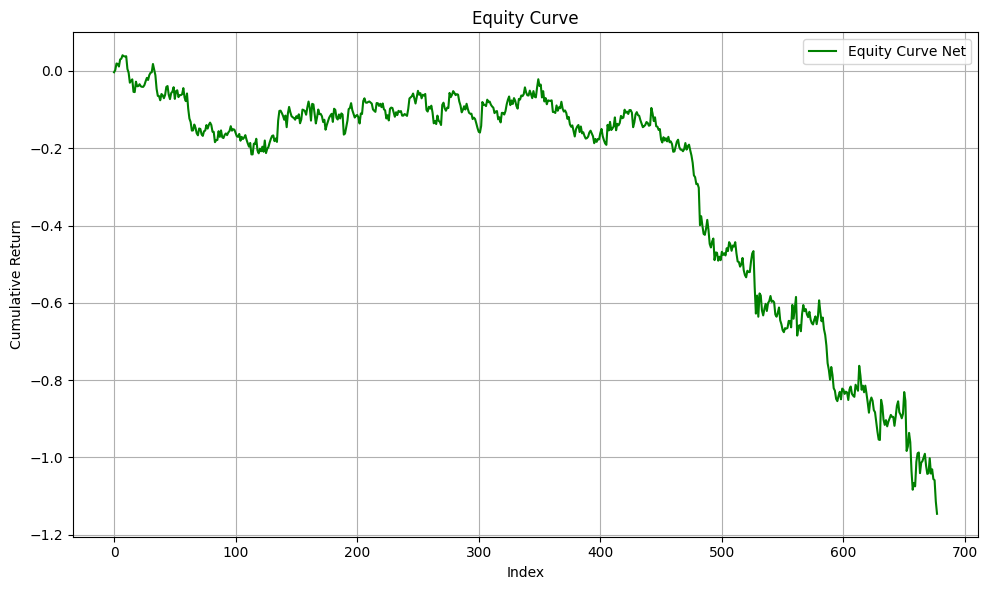

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(trade_results['equity_curve_net'], label='Equity Curve Net', color='green')
plt.xlabel('Index')
plt.ylabel('Cumulative Return')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()